In [1]:
import psfr
from psfr.psfr import shift_psf, one_step_psf_estimate

import astropy.io.fits as pyfits
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy
from scipy.ndimage import interpolation
from lenstronomy.Util import util, kernel_util, image_util
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

%load_ext autoreload
%autoreload 2

vmin, vmax = -5, -1  # log10 minimum and maximum scale being plotted in PSF

In [2]:
def max2d(array):
    shp = np.shape(array)
    imax = np.argmax(array)
    i1,i2 = int(imax/shp[1]),imax%shp[1]
    return i1,i2

In [3]:
filename200 = '../smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f200w/jw02736-o001_t001_nircam_clear-f200w_i2d.fits'#'smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits'
data200 = fits.open(filename200)

filename150 = '../smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f150w/jw02736-o001_t001_nircam_clear-f150w_i2d.fits'#'smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits'
data150 = fits.open(filename150)

filename090 = '../smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits'#'smacs_0723/JWST/jw02736-o001_t001_nircam_clear-f090w/jw02736-o001_t001_nircam_clear-f090w_i2d.fits'
data090 = fits.open(filename090)

print(np.shape(data200[1].data))
print(np.shape(data150[1].data))
print(np.shape(data090[1].data))

dataarr = np.flip(data200[1].data,axis=1)
dataarr_err = np.flip(data200[2].data,axis=1)

dataarr = dataarr[:4750,:4750]
dataarr_err = dataarr_err[:4750,:4750] 

coverage_mask = (dataarr == 0)

dataarr2 = np.flip(data150[1].data,axis=1)
dataarr_err2 = np.flip(data150[2].data,axis=1)

dataarr2 = dataarr2[:4750,:4750]
dataarr_err2 = dataarr_err2[:4750,:4750] 

coverage_mask2 = (dataarr2 == 0)

dataarr3 = np.flip(data090[1].data,axis=1)
dataarr_err3 = np.flip(data090[2].data,axis=1)

dataarr3 = dataarr3[:4750,:4750]
dataarr_err3 = dataarr_err3[:4750,:4750] 

coverage_mask3 = (dataarr3 == 0)

(4766, 10276)
(4735, 10240)
(4758, 10272)


0.0
1.3141986083984376


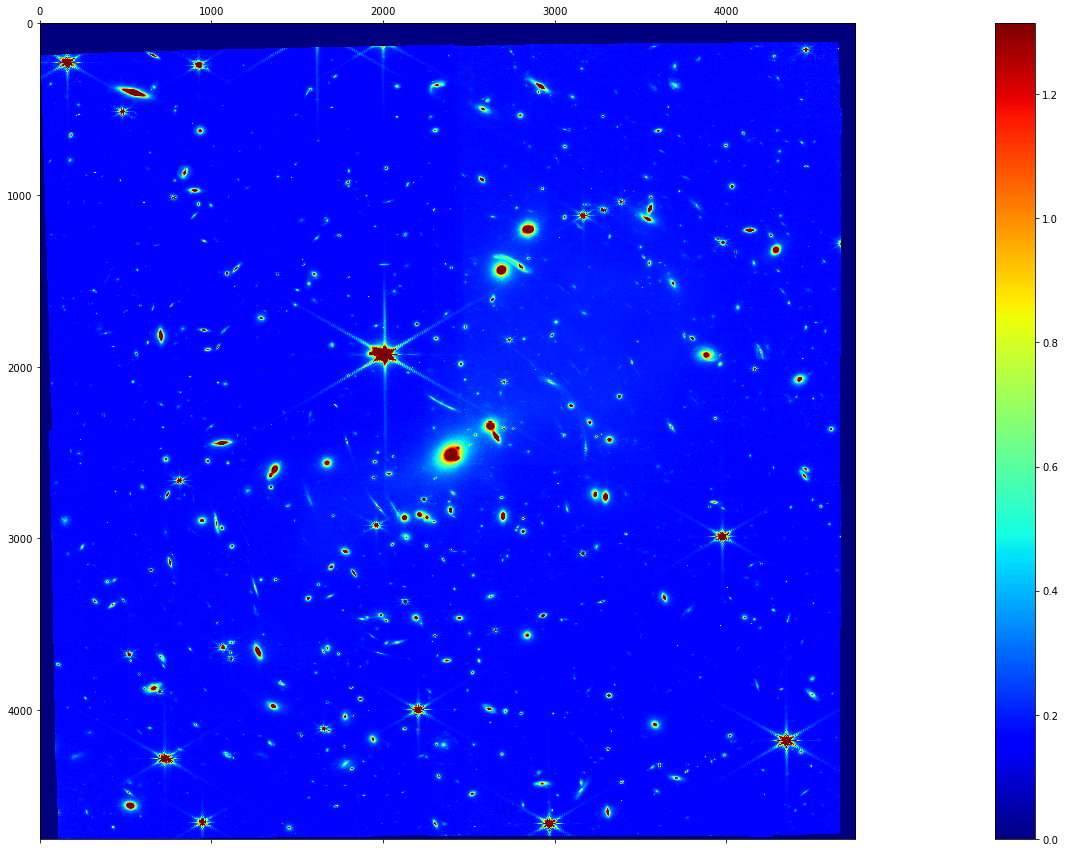

In [4]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise

f, axes = plt.subplots(1, 1, figsize=(50,15), sharex=False, sharey=False)
ax = axes

vmin = 0.
vmax = np.max(dataarr)/500.
print(vmin)
print(vmax)

#ext = 1.

#extent = [-ext,ext,-ext,ext]

im0 = ax.matshow(dataarr, origin='upper', vmin=vmin, vmax=vmax, cmap='jet')
#ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].get_yaxis().set_visible(False)
ax.autoscale(False)
f.colorbar(im0, ax=axes)

In [5]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(dataarr, (30, 30), filter_size=(19, 19),mask=coverage_mask, exclude_percentile = 50.,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,edge_method='crop')

bkg2 = Background2D(dataarr2, (30, 30), filter_size=(19, 19),mask=coverage_mask2, exclude_percentile = 50.,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,edge_method='crop')

bkg3 = Background2D(dataarr3, (30, 30), filter_size=(19, 19),mask=coverage_mask3, exclude_percentile = 50.,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,edge_method='crop')

0.0
0.27286507934331894


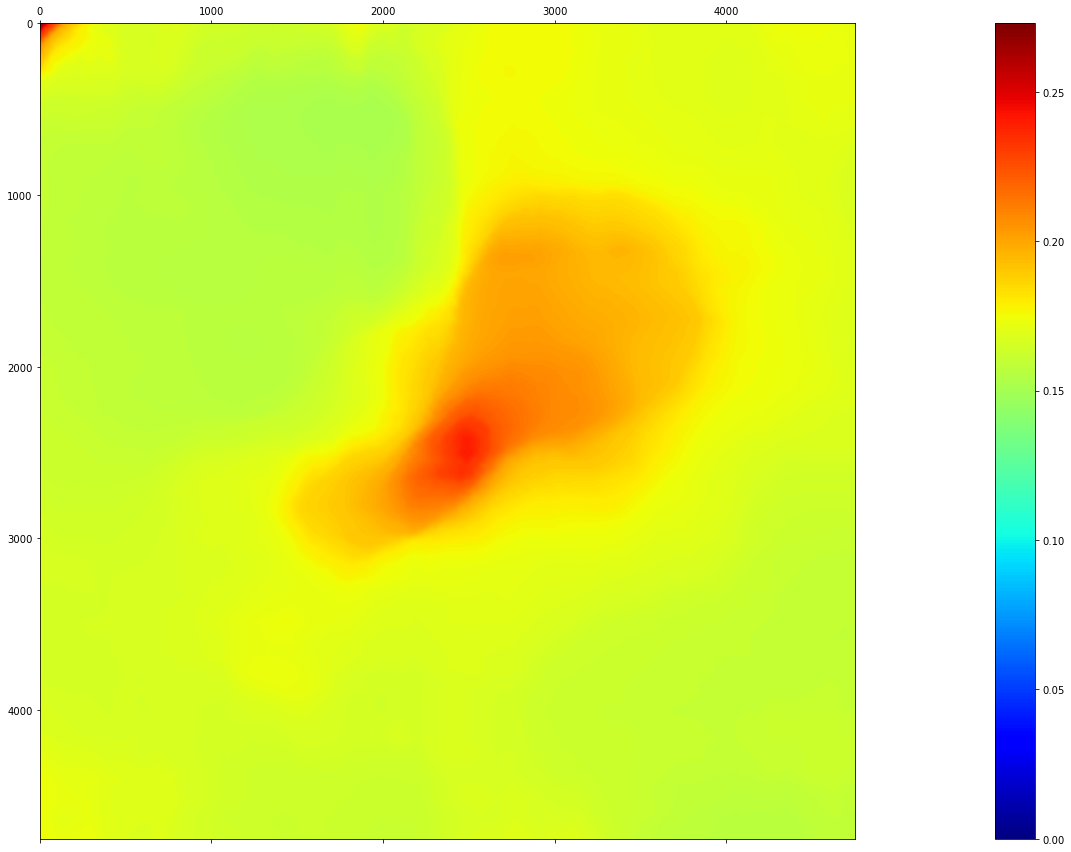

In [6]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise

f, axes = plt.subplots(1, 1, figsize=(50,15), sharex=False, sharey=False)
ax = axes

vmin = 0.
vmax = np.max(bkg.background)
print(vmin)
print(vmax)

#ext = 1.

#extent = [-ext,ext,-ext,ext]

im0 = ax.matshow(bkg.background, origin='upper', vmin=vmin, vmax=vmax, cmap='jet')
#ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].get_yaxis().set_visible(False)
ax.autoscale(False)
f.colorbar(im0, ax=axes)

In [7]:
dataarr = dataarr-bkg.background

dataarr2 = dataarr2-bkg2.background

dataarr3 = dataarr3-bkg3.background

In [8]:
size = 60

yc3 = 2430
xc3 = 1783

ymin3 = yc3-size
ymax3 = yc3+size

xmin3 = xc3-size
xmax3 = xc3+size

array200sci = dataarr[ymin3:ymax3,xmin3:xmax3]
array200err = dataarr_err[ymin3:ymax3,xmin3:xmax3]

yc3 = 2826
xc3 = 1975

ymin3 = yc3-size
ymax3 = yc3+size

xmin3 = xc3-size
xmax3 = xc3+size

array200sci2 = dataarr[ymin3:ymax3,xmin3:xmax3]
array200err2 = dataarr_err[ymin3:ymax3,xmin3:xmax3]

yc3 = 3121
xc3 = 2345

ymin3 = yc3-size
ymax3 = yc3+size

xmin3 = xc3-size
xmax3 = xc3+size

array200sci3 = dataarr[ymin3:ymax3,xmin3:xmax3]
array200err3 = dataarr_err[ymin3:ymax3,xmin3:xmax3]

-1.2
0.5


<ipython-input-9-d5ebbaba6592>:40: RuntimeWarning: invalid value encountered in log10
  im0 = axbig.imshow(np.log10(dataarr), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
<ipython-input-9-d5ebbaba6592>:95: RuntimeWarning: invalid value encountered in log10
  im0 = ax[3,0].imshow(np.log10(array200sci), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
<ipython-input-9-d5ebbaba6592>:96: RuntimeWarning: invalid value encountered in log10
  im0 = ax[3,1].imshow(np.log10(array200sci2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
<ipython-input-9-d5ebbaba6592>:97: RuntimeWarning: invalid value encountered in log10
  im0 = ax[3,2].imshow(np.log10(array200sci3), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)


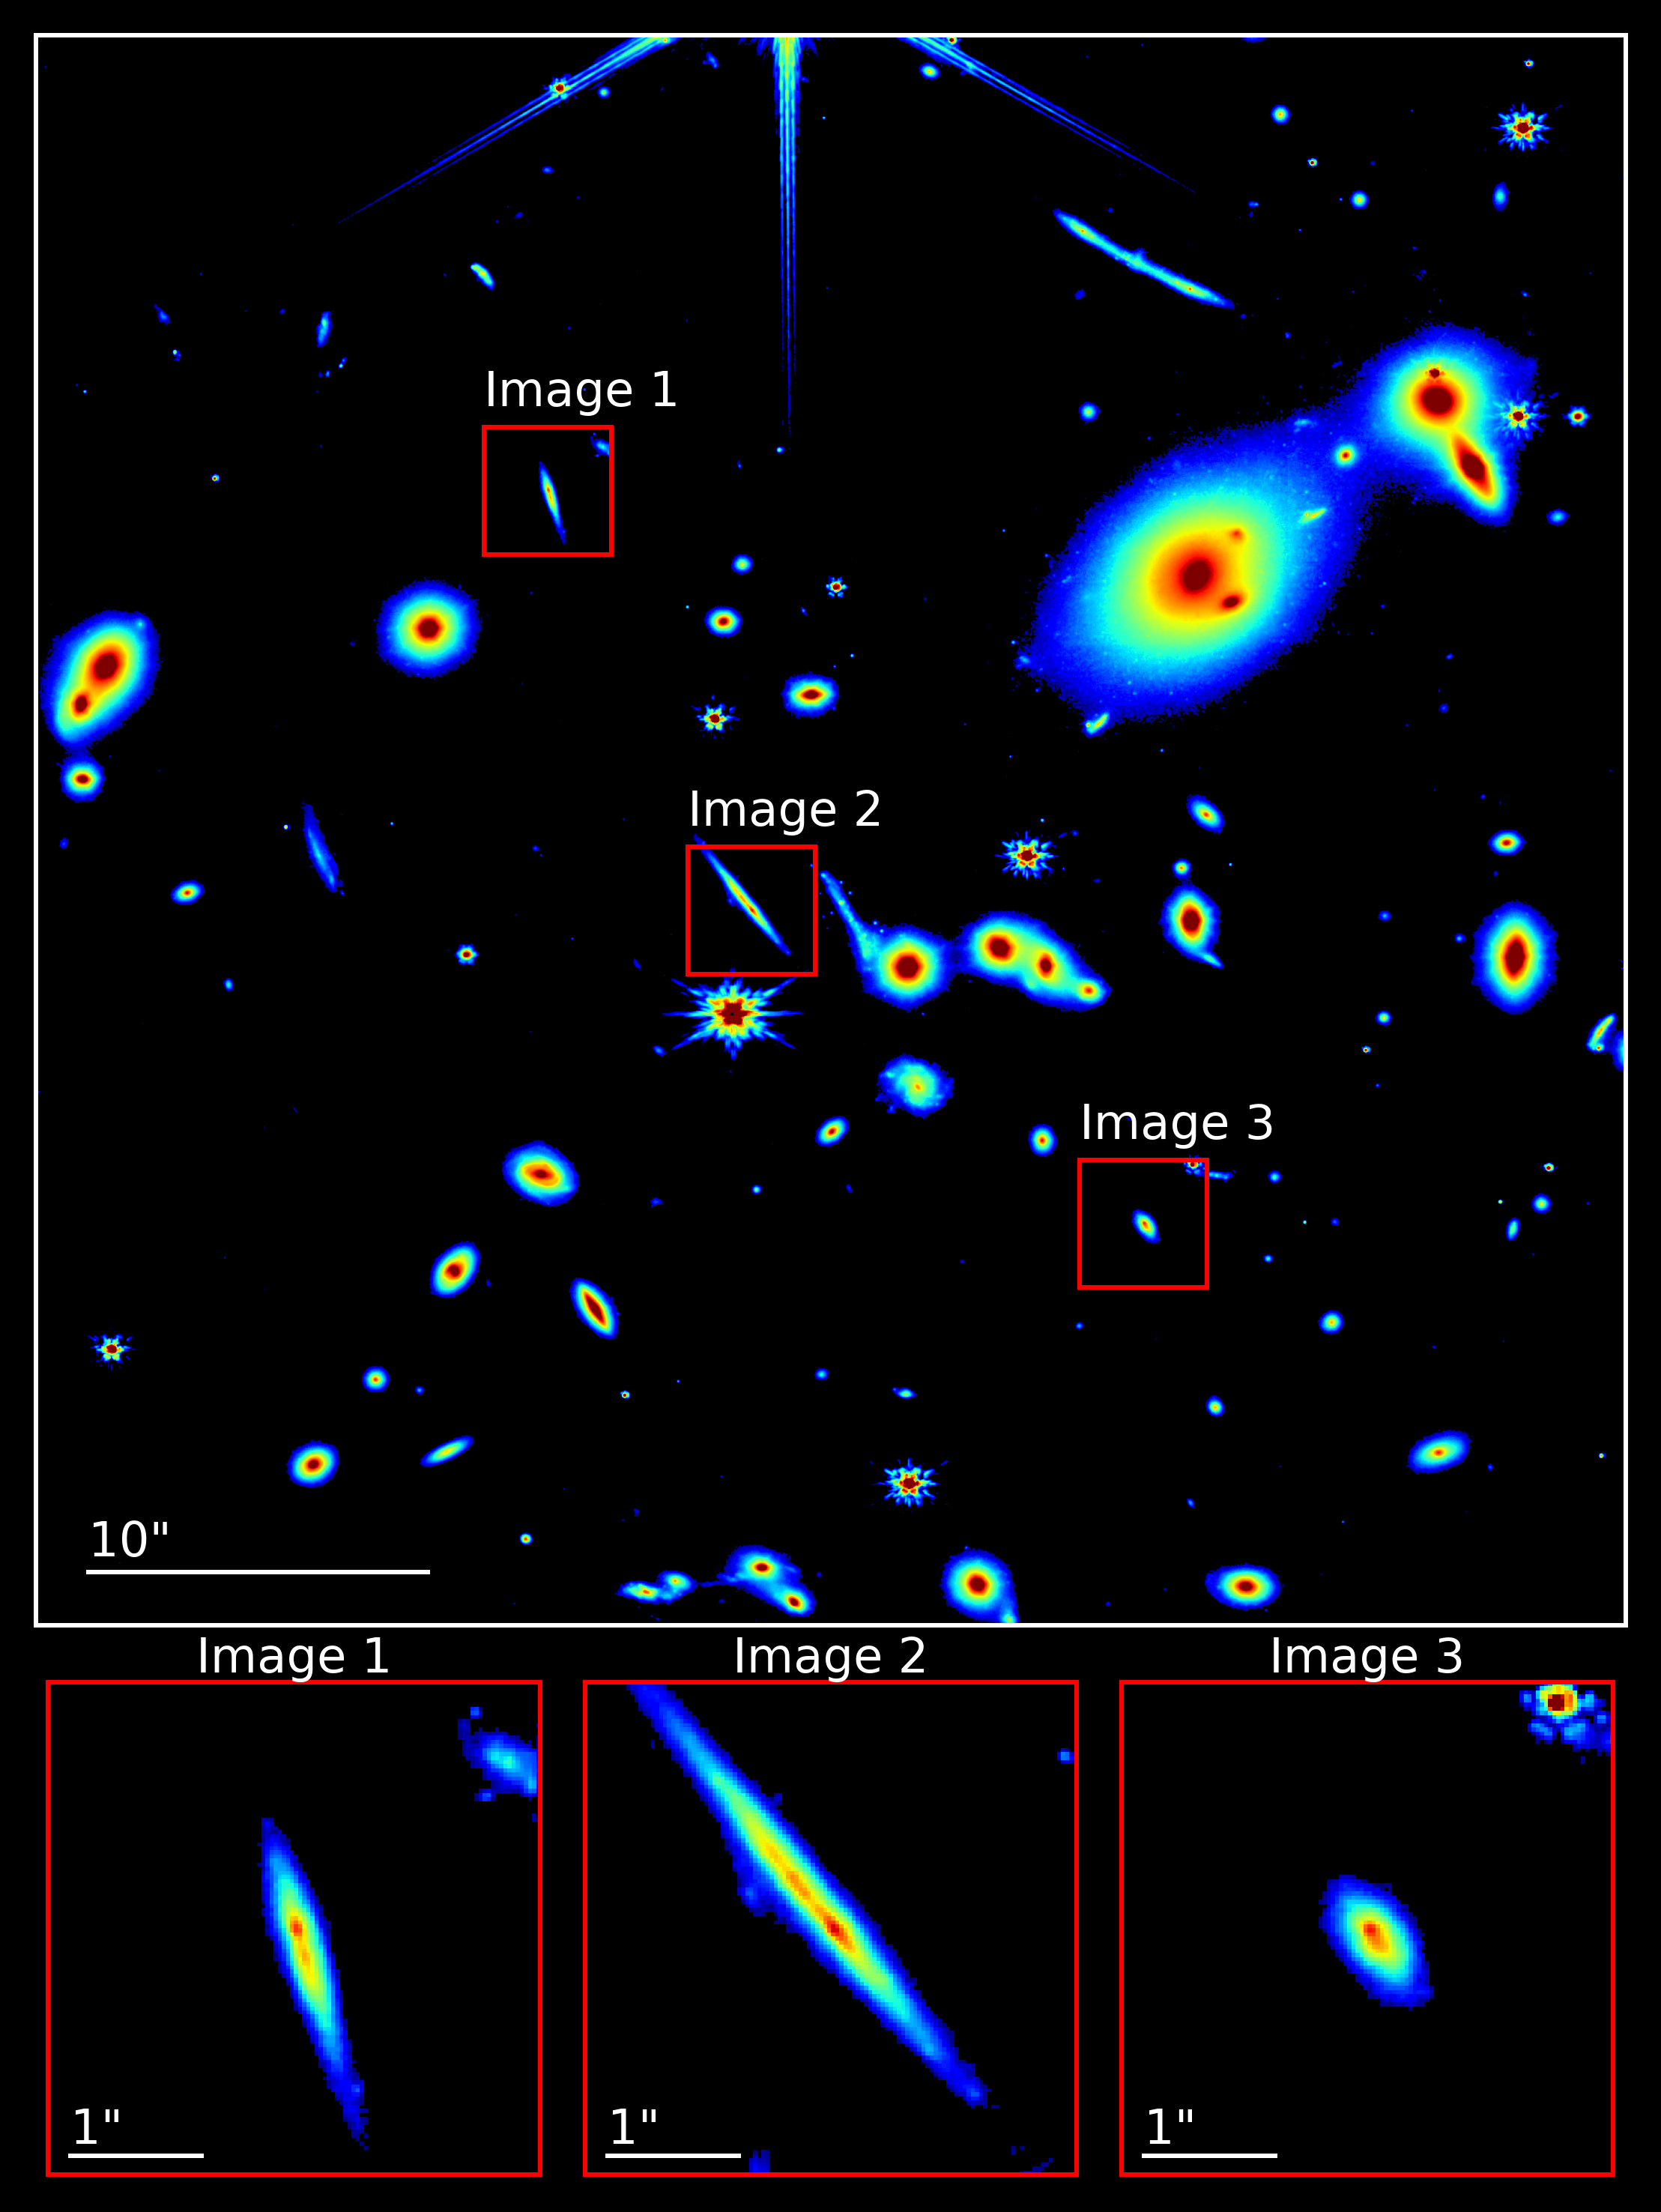

In [9]:
import matplotlib as mpl
import matplotlib.lines as lines

cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')



# here we plot full image of the signal and the noise

scal = 2.

f, axes = plt.subplots(4, 3, figsize=(15*scal,20*scal))


f.patch.set_facecolor('black')

ax = axes
gs = axes[1, 0].get_gridspec()

fontsss = 32

for axi in axes[:3, :]:
    for axij in axi:
        axij.remove()

vmin = -1.2
vmax = 0.5
print(vmin)
print(vmax)

#ext = 1.

#extent = [-ext,ext,-ext,ext]

axbig = f.add_subplot(gs[:3, :])

im0 = axbig.imshow(np.log10(dataarr), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
deltaPix = 0.031230659851709842

txtclr = 'white'

x1 = [1350,1350+10/deltaPix]
y1 = [3450,3450]
axbig.add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
axbig.text(1350,3435, '10"', fontsize = fontsss*scal,color=txtclr)

#ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].get_yaxis().set_visible(False)
#rectangle = plt.Rectangle((1733,2370), 120, 120, fill=None,ec="red",linewidth=10)
rectangle1 = mpl.patches.Rectangle((1783-size,2430-size), 120, 120, fill=None,ec="red",linewidth=3*scal)
rectangle2 = mpl.patches.Rectangle((1975-size,2826-size), 120, 120, fill=None,ec="red",linewidth=3*scal)
rectangle3 = mpl.patches.Rectangle((2345-size,3121-size), 120, 120, fill=None,ec="red",linewidth=3*scal)




axbig.text(1783-size,2430-size-20, 'Image 1', fontsize = fontsss*scal,color=txtclr)
axbig.text(1975-size,2826-size-20, 'Image 2', fontsize = fontsss*scal,color=txtclr)
axbig.text(2345-size,3121-size-20, 'Image 3', fontsize = fontsss*scal,color=txtclr)


axbig.add_patch(rectangle1)
axbig.add_patch(rectangle2)
axbig.add_patch(rectangle3)


axbig.set_xticks([])
axbig.set_yticks([])

axbig.set_xticklabels([])
axbig.set_yticklabels([])



axbig.autoscale(False)
axbig.set_xlim(1300,2800)
axbig.set_ylim(3500,2000)

for direc in ['left', 'right', 'top', 'bottom']:

    axbig.spines[direc].set_color('white') 
    axbig.spines[direc].set_linewidth(3*scal)





ax[3,0].set_title('Image 1',fontsize = fontsss*scal, color=txtclr)
ax[3,1].set_title('Image 2',fontsize = fontsss*scal, color=txtclr)
ax[3,2].set_title('Image 3',fontsize = fontsss*scal, color=txtclr)

im0 = ax[3,0].imshow(np.log10(array200sci), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[3,1].imshow(np.log10(array200sci2), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)
im0 = ax[3,2].imshow(np.log10(array200sci3), origin='upper', vmin=vmin, vmax=vmax, cmap=cmap)


x1 = [5,5+1/deltaPix]
y1 = [115,115]
ax[3,0].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[3,0].text(5,112, '1"', fontsize = fontsss*scal,color=txtclr)

ax[3,1].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[3,1].text(5,112, '1"', fontsize = fontsss*scal,color=txtclr)


ax[3,2].add_artist(lines.Line2D(x1, y1,color="white", linewidth=3*scal))
ax[3,2].text(5,112, '1"', fontsize = fontsss*scal,color=txtclr)


for axk in ax[3,:]:
    axk.set_xticklabels([])
    axk.set_yticklabels([])
    
    axk.set_xticks([])
    axk.set_yticks([])
    
    for direc in ['left', 'right', 'top', 'bottom']:
        
        axk.spines[direc].set_color('red') 
        axk.spines[direc].set_linewidth(3*scal)

#f.colorbar(im0, ax=axes)
#plt.plot(x1,y1,color="white", linewidth=3*scal,linestyle='dashed')
f.add_artist(lines.Line2D([-0.01, 1.01], [1.01, -0.01],alpha=0.))
plt.tight_layout()


In [10]:
quincunx = np.array([[0.,-1.,0.],[-1.,4.,-1.],[0.,-1.,0.]])
print(quincunx)

[[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]


In [11]:
from scipy import signal
gradientsci = signal.convolve2d(dataarr, quincunx, boundary='fill', mode='same')

In [12]:
def makeflat(arr):
    shp = np.shape(arr)
    tot = np.prod(shp)
    flatarr = np.reshape(arr,tot)
    return flatarr,shp

def getorderedindices(arr):
    flatarr,shp = makeflat(arr)
    indices = np.argsort(flatarr)
    ind2d = []
    
    for i in range(len(indices)):
        ind2d.append([indices[i]%shp[1],int(indices[i]/shp[1])])
    return indices,np.array(ind2d)

In [ ]:
idcs,idcs2d = getorderedindices(gradientsci)

In [ ]:
star_ind_list = [411,488,494,581,582,654,666,668,723,740,753,794,823,832,839,863,908,976]
new_star_list = []
poslist = []

In [ ]:
for i in star_ind_list:
    vmin = np.log10(np.max(gradientsci))-5.
    vmax = np.log10(np.max(gradientsci))

    vmin2 = np.log10(np.max(dataarr))-4.5
    vmax2 = np.log10(np.max(dataarr))

    size = 45

    indx = i

    star = dataarr[idcs2d[-indx][1]-size:idcs2d[-indx][1]+size+1,idcs2d[-indx][0]-size:idcs2d[-indx][0]+size+1]
    gradstar = gradientsci[idcs2d[-indx][1]-size:idcs2d[-indx][1]+size+1,idcs2d[-indx][0]-size:idcs2d[-indx][0]+size+1]

    new_star_list.append(star)
    poslist.append(np.array([idcs2d[-indx][1],idcs2d[-indx][0]]))
    
    vmaxstr = np.log10(np.max(star))

    print(idcs2d[-indx][1],idcs2d[-indx][0])
    print(vmax)
    print(vmaxstr)

In [ ]:
star = new_star_list[3]
print(poslist[3])

cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise

f, axes = plt.subplots(1, 1, figsize=(10,8), sharex=False, sharey=False)
ax = axes

im0 = ax.matshow(np.log10(star), origin='upper', vmin=vmin2, vmax=vmax2, cmap='jet')
#ax[0,0].get_xaxis().set_visible(False)
#ax[0,0].get_yaxis().set_visible(False)
f.colorbar(im0, ax=axes)
plt.show()

In [18]:
from psfr.psfr import stack_psf

psf_psfr2, center_list_psfr2, mask_list2 = stack_psf(new_star_list, oversampling=1, 
                                                  saturation_limit=None, num_iteration=100, 
                                                  n_recenter=100)

In [19]:
# supersampled comparison between PSF-r and photutils

f, axes = plt.subplots(1, 1, figsize=(10*3, 10), sharex=False, sharey=False)

vmin, vmax = -5, -1
ax = axes
im = ax.imshow(np.log10(psf_psfr2), origin='lower', vmin=vmin, vmax=vmax)
ax.autoscale(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('PSF-r method')
plt.show()

In [ ]:
np.save('jwst_psf_200.npy',psf_psfr2)